# Исследование активности пользователей StackOverflow.

Мы располагаем базой данных StackOverflow — сервиса вопросов и ответов о программировании. StackOverflow похож на социальную сеть — пользователи сервиса задают вопросы, отвечают на посты, оставляют комментарии и ставят оценки другим ответам.
Исследуем версию базы, где хранятся данные о постах за 2008 год, но в таблицах присутствует информация и о более поздних оценках, которые эти посты получили.

Цель исследования - изучить активность пользователей платформы в 2008 году.
Задачи исследования - ответь на вопросы согласно списку.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой мы будем работать в проекте

In [2]:
db_config = {
    'user': '--', # имя пользователя
    'pwd': '--', # пароль
    'host': '--',
    'port': ----, # порт подключения
    'db': '----' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

## Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [4]:
query = '''
SELECT DATE_TRUNC('month', creation_date) as month_date,
    SUM(views_count) 
FROM stackoverflow.posts
GROUP BY month_date
ORDER BY 2 DESC;
'''
sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,month_date,sum
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Пик активности по просмотрам постов в 2008 году пришелся на сентябрь - месяц официального открытия платформы и максимального привлечения внимания к ресурсу. Далее до конца года активность плавно снижается, ажиотаж спадает, над удержанием пользователей стоит работать, первый вау-эффект прошел. В июле самое маленькое число просмотров - вероятно, это тестовые просмотры команды-разработчиков и первых пользователей. В августе количество просмотров возросло, вероятная причина в активной рекламе проекта (подготовка к открытию платформы).

## Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [6]:
query = '''
SELECT *
FROM stackoverflow.post_types
'''
post_types = pd.read_sql_query(query, con=engine) 

In [7]:
post_types

,id,type
0,1,Question
1,2,Answer


In [8]:
query = '''
SELECT u.display_name,
       COUNT(DISTINCT p.user_id) 
FROM stackoverflow.posts as p
JOIN stackoverflow.users as u ON p.user_id=u.id
WHERE (post_type_id = 2) AND (p.creation_date <= (DATE_TRUNC('day',u.creation_date) + INTERVAL'29 days'))
GROUP BY u.display_name
ORDER BY display_name 
'''
post1 = pd.read_sql_query(query, con=engine) 

In [9]:
post1.head(50)

,display_name,count
0,0124816,1
1,0bytes,1
2,1077,1
3,108,1
4,10goto10,1
5,17 of 26,1
6,1729,1
7,1800 INFORMATION,1
8,18Rabbit,1
9,18hrs,1


In [10]:
post1.sort_values(by=['count'], ascending=False).head(10)

,display_name,count
5248,Matt,29
1351,Chris,28
1794,Dan,21
3641,Jason,19
8088,Tom,19
1949,Dave,19
2007,David,19
5569,Mike,17
790,Ben,17
5925,Nick,16


Активные пользователи не обязательно указывают для отображения на платформе свое настоящее имя или вразумительный псевдоним. Встречаются "ники" из цифр, набора букв, аббревиатур и сокращений. Вероятно эти люди не хотят публичности, или наоборот таким образом выделяются. Платформа допускает дубли имен. Например, существует 11 активных пользователей с ником Aaron. Наиболее популярные ники Matt, Chris, Dan, Jason and Tom - обычные мужские имена.

## Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [11]:
query = '''
SELECT DATE_TRUNC('month', p.creation_date) as month,
    COUNT(p.id)
FROM stackoverflow.posts as p
WHERE p.user_id IN (SELECT DISTINCT u.id
                    FROM stackoverflow.posts as p
                    JOIN stackoverflow.users as u ON p.user_id=u.id
                    WHERE (u.creation_date::date >= '2008-09-01' 
                            AND u.creation_date::date <= '2008-09-30') 
                            AND (p.creation_date::date >= '2008-12-01' 
                                AND p.creation_date::date <= '2008-12-31'))
GROUP BY month
ORDER BY month DESC
'''

posts2 = pd.read_sql_query(query, con=engine) 

In [12]:
posts2

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Пользователи, зарегистрировавшиеся в сентябре, наибольшую активность проявили в октябре. Далее их активность плавно снижалась. Но, имеется 32 поста этих пользователей в августе. Вероятно была возможность писать посты без регистрации до открытия платформы. Или регистрацию всех пользователей до сентября по каким-то причинам сбросили на сентябрь.

## Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [13]:
query = '''
SELECT user_id,
    creation_date,
    views_count,
    SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date) as cumulative_count
FROM stackoverflow.posts
ORDER BY 1,
    2;
'''

posts3 = pd.read_sql_query(query, con=engine) 

In [14]:
posts3.head(10)

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
5,1,2008-08-04 08:04:42,0,616509
6,1,2008-08-10 08:28:52,0,616509
7,1,2008-08-11 19:23:47,0,616509
8,1,2008-08-12 00:30:43,0,616509
9,1,2008-08-12 04:59:35,72431,688940


## Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [15]:
query = '''
WITH tab AS
(SELECT user_id,
    DATE_TRUNC('day', creation_date),
    COUNT(id) as day_sum
FROM stackoverflow.posts
WHERE DATE_TRUNC('day', creation_date) >= '2008-08-01' 
      AND DATE_TRUNC('day', creation_date) <= '2008-08-31'
GROUP BY 1, 2),

tab1 as
(SELECT *,
    SUM(day_sum) OVER(PARTITION BY user_id)
FROM tab)

SELECT user_id,
    AVG(day_sum)
FROM tab1
WHERE sum >= 120
GROUP BY user_id
ORDER BY avg
'''

posts_avg = pd.read_sql_query(query, con=engine) 

In [16]:
posts_avg

,user_id,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


## Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [17]:
query = '''
WITH tab as
(SELECT user_id,
    DATE_TRUNC('day', creation_date),
    COUNT(id) as sum_posts
FROM stackoverflow.posts
WHERE DATE_TRUNC('day', creation_date) >= '2008-12-01' 
      AND DATE_TRUNC('day', creation_date) <= '2008-12-07'
GROUP BY 1, 2
HAVING  COUNT(id) > 0),
tab1 as
(SELECT user_id,
    COUNT(date_trunc)
FROM tab
GROUP BY user_id)
SELECT ROUND(AVG(count))
FROM tab1

'''

posts_days = pd.read_sql_query(query, con=engine) 

In [18]:
posts_days

,round
0,2.0


Всреднем каждый пользователь с 1 го 7 декабря 2008 года посещал платформу StackOverflow дважды.

## Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [19]:
query = '''
SELECT user_id,
    creation_date,
    LAG( TO_CHAR(creation_date, 'Month'), 2, NULL) OVER(PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY 1, 2
'''

posts_active = pd.read_sql_query(query, con=engine) 

In [20]:
posts_active.head(10)

,user_id,creation_date,lag
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
5,1,2008-08-04 08:04:42,August
6,1,2008-08-10 08:28:52,August
7,1,2008-08-11 19:23:47,August
8,1,2008-08-12 00:30:43,August
9,1,2008-08-12 04:59:35,August


## Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [21]:
query = '''
WITH user_profile as
(SELECT *,
    COUNT(user_id) OVER(PARTITION BY cohort_dt) as cohort_users_cnt
FROM (SELECT DISTINCT user_id,
             FIRST_VALUE(DATE_TRUNC('month', creation_date)) OVER(PARTITION BY user_id ORDER BY creation_date) as cohort_dt
      FROM stackoverflow.posts) as tabl
),

sessions as
(SELECT DISTINCT user_id,
       DATE_TRUNC('month', creation_date) as session_date
FROM stackoverflow.posts)

SELECT up.cohort_dt,
    s.session_date,
    COUNT(s.user_id) as users_cnt,
    up.cohort_users_cnt,
    ROUND(COUNT(s.user_id) * 100.0 / up.cohort_users_cnt, 2) as retention_rate
FROM sessions as s 
LEFT JOIN user_profile as up ON s.user_id=up.user_id
GROUP BY 1, 2, 4;
'''

retention = pd.read_sql_query(query, con=engine) 

In [22]:
retention

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


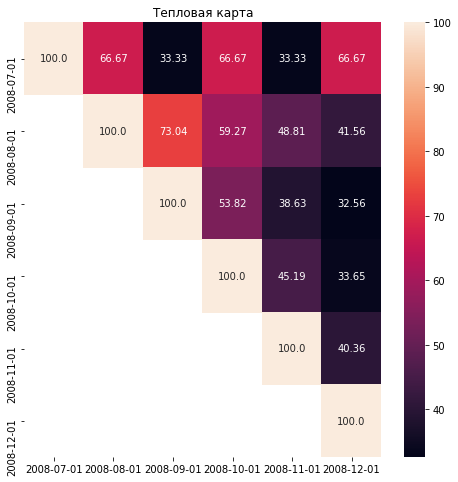

In [23]:
# создаём сводную таблицу с результатами
retention_pivot = retention.pivot('cohort_dt', 'session_date', 'retention_rate')
retention_pivot.index = [str(x)[0:10] for x in retention_pivot.index]
retention_pivot.columns = [str(x)[0:10] for x in retention_pivot.columns]

# строим хитмэп
plt.figure(figsize=(8, 8)) 
sns.heatmap(retention_pivot, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта') 
plt.show()

   - Когорта в июле очень маленькая - 3 человека. Вероятно, разработчики платформы. Анализировать их удержание некорректно, так как скорее всего они пишут посты по работе.
   - Удержание пользователей, пришедших в августе (еще до официального открытия платформы), самое высокое - 73% после первого месяца использования. Это фанаты, которые открыты всему новому, готовы использовать еще сырой продукт, очень благонастроены - они не отражают среднего пользователя. Их удержание 5го месяца 41% что выше, чем удержание 2го-3го месяца последующих когорт.
   - Удержание пользователей, пришедших в сентябре, после 1 месяца использования платформы составило 54% - на 20% ниже, чем удержание августовских пользователей. Удержание 2го месяца новых когорт пришедших далее в 2008 году еще ниже 45% и 40%. 
   - Пользователи к нам не возвращаются. Количество пользователей в когортах так же подтверждает снижение интереса к платформе: более 7600 в сентябре, а в октябре уже на 50% меньше 3600, в ноябре и декабре сохранилась тенденция к снижению количества привлекаемых пользователей. 
   
   Стоит обратить внимание на каналы привлечения и способы удержания.

## Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [24]:
query = '''
WITH tab as
(SELECT EXTRACT('month' FROM creation_date) as creation_month,
    COUNT(id) as posts_count   
FROM stackoverflow.posts
WHERE creation_date >= '2008-09-01' AND creation_date <= '2008-12-31'
GROUP BY EXTRACT('month' FROM creation_date))

SELECT *,
    ROUND((posts_count - LAG(posts_count) OVER(ORDER BY creation_month))*100.0 / LAG(posts_count) OVER(ORDER BY creation_month), 2)
FROM tab
'''

posts_cnt = pd.read_sql_query(query, con=engine) 

In [25]:
posts_cnt

,creation_month,posts_count,round
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

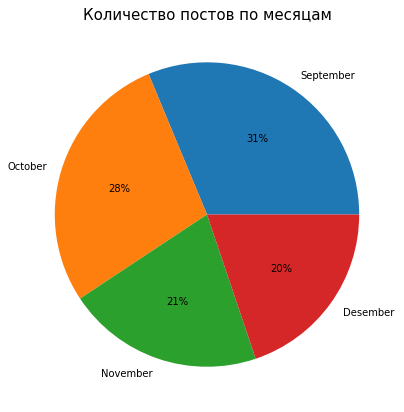

In [26]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.pie(posts_cnt['posts_count'], 
        labels = ['September', 'October', 'November', 'Desember'],
        autopct='%.0f%%'
       )

ax.set_title('Количество постов по месяцам', fontsize = 15)
plt.show()

## Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [27]:
query = '''
WITH tab as
(SELECT user_id,
 COUNT(id)
FROM stackoverflow.posts
GROUP BY user_id
ORDER BY count DESC
LIMIT 1)

SELECT DISTINCT EXTRACT(week from creation_date) as week_creation,
                LAST_VALUE(creation_date) OVER(PARTITION BY EXTRACT(week from creation_date) ORDER BY creation_date ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING)
FROM stackoverflow.posts as p
JOIN tab ON p.user_id=tab.user_id
WHERE creation_date >= '2008-10-01' AND creation_date <= '2008-10-31'

'''


active_user = pd.read_sql_query(query, con=engine)

In [28]:
active_user

,week_creation,last_value
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-30 22:50:00
